In [24]:
from __future__ import print_function 

#%load_ext autoreload
#%autoreload 2

from matplotlib import pyplot as plt
%matplotlib inline

import os, sys
import numpy as np
import time

import tensorflow as tf

import pandas as pd
import pickle
import gc, re, copy
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils

# Project imports 
from data import mnist,mnist_m
from data.tasks import *
from data.label_shift import label_shift_linear, plot_labeldist, plot_splitbars
from experiments.training import *
from experiments.SL_bound import *
from util.kl import *
from util.misc import *
from results.plotting import *

# Hyper-parameters
#batch_size = 128
num_classes = 10
make_plots = False

delta=0.05 ## what would this be?   

alphas=[0]
#length=10
#for i in range(length-1):
#    alphas.append((i+1)/length)



sigmas=[]
for i in range(2,9):  
    sigmas.append([3,i])
    if(i==8):
        break
    sigmas.append([1,i])

img_rows, img_cols = 32, 32
project_folder = "/cephyr/users/adambre/Alvis/"


### TODO

# # check output_dir, create it if not exists
#     if not os.path.isdir(output_dir):
#         os.makedirs(output_dir)

# Load data

In [44]:
import time
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import collections
import csv


#data_path="/home/adam/Code/Datasets/chexpert/1.0.0/"
#data_path2="/home/adam/Code/Datasets/chexpert/CheXpert-v1.0-small"
def tf_read_and_resize_image(filename,img_size):
    ### takes file path and image size and resizes the image
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image=tf.cast(image, tf.float32)
    image = tf.image.resize(image, (img_size, img_size))#, method=tf.image.ResizeMethod.BILINEAR)
    return image

def load_from_csv(imgs_path,csv_path):
    _LABELS = collections.OrderedDict({
            "-1.0": "uncertain",
            "1.0": "positive",
            "0.0": "negative",
            "": "unmentioned",
        })
    labeldict={"positive":1,"negative":0, "unmentioned":0,"uncertain":1} ### sets all uncertain labels to 1
    overlapping_labels=[0,2,5,6,8,10] ## according to pham et al. NF,CM,ED,CD,AC,PE
    ##### loads chexpert filenames and labels from files
    label_arr=[]
    arr=[]
    with tf.io.gfile.GFile(csv_path) as csv_f:
        reader = csv.DictReader(csv_f)
        # Get keys for each label from csv
        label_keys = reader.fieldnames[5:]

        for row in reader:
            # Get image based on indicated path in csv
            name = row["Path"]
            labels = [_LABELS[row[key]] for key in label_keys]
            labels_overlap=[labeldict[labels[i]] for i in overlapping_labels]

            ## save the image_name and the label array
            label_arr.append(labels_overlap)
            arr.append(os.path.join(imgs_path, name))
        return arr,label_arr
    
def make_xray14_labels():
    ##### load the labels and convert the labels to binary vectors which maps the occurrence of a label to a 1
    data_path="/home/adam/Code/Datasets/chestXray14/"
    labeldict={"No Finding":0,"Cardiomegaly":1,"Edema":2,"Consolidation":3,"Atelectasis":4,"Effusion":5}
    data = pd.read_csv(data_path+"Data_Entry_2017_v2020.csv")
    sample = os.listdir(data_path+"resized32/")

    sample = pd.DataFrame({'Image Index': sample})

    sample = pd.merge(sample, data, how='left', on='Image Index')

    sample.columns = ['Image_Index', 'Finding_Labels', 'Follow_Up_#', 'Patient_ID',
                      'Patient_Age', 'Patient_Gender', 'View_Position',
                      'Original_Image_Width', 'Original_Image_Height',
                      'Original_Image_Pixel_Spacing_X',
                      'Original_Image_Pixel_Spacing_Y']#, 'Unnamed']
    def make_one_hot(label_string):
        result=np.zeros(6)
        labels=label_string.split('|')
        for l in labels:
            if l not in ["No Finding","Cardiomegaly","Edema","Consolidation","Atelectasis","Effusion"]:
                pass
            else:
                result[labeldict[l]]=1
        return result.astype(int)

    sample['Finding_Labels'] = sample['Finding_Labels'].apply(lambda x: make_one_hot(x))
    print(sample['Finding_Labels'].shape)
    y=sample['Finding_Labels']
    return y

def load_resize_and_save(chexpert=False,img_size=32):
##### loads the xray datasets from the raw images and then resizes to desired size and saves them in a new directory
    if chexpert:
        data_path="/home/adam/Code/Datasets/chexpert/"
        _DATA_DIR = "/home/adam/Code/Datasets/chexpert/CheXpert-v1.0-small" ### where is the source data?
        _TRAIN_DIR = os.path.join(_DATA_DIR, "train")
        _VALIDATION_DIR = os.path.join(_DATA_DIR, "valid")
        _TRAIN_LABELS_FNAME = os.path.join(_DATA_DIR, "train.csv")
        _VALIDATION_LABELS_FNAME = os.path.join(_DATA_DIR, "valid.csv")
        
        filenames,labels=load_from_csv(data_path,_TRAIN_LABELS_FNAME)
        
        filenames_2,labels_2=load_from_csv(data_path,_VALIDATION_LABELS_FNAME)

        filenames.extend(filenames_2)
        labels.extend(labels_2)
     
        new_path=data_path+"resized"+str(img_size)+"chex"
        if not os.path.exists(new_path):
            os.makedirs(new_path)
        ## load in, resize and save image in array file
        for file in filenames:
            img=np.array(tf_read_and_resize_image(file,img_size))
            tf.keras.preprocessing.image.save_img(new_path,img)
            sys.exit(-1)
            
        #np.save("/home/adam/Code/Datasets/chexpert/chexpert128.npy",np.array([np.array(tf_read_and_resize_image(file)) for file in filenames]))
        #np.save("/home/adam/Code/Datasets/chexpert/labels.npy",np.array(labels)) # save labels to separate file
    else:
        data_path="/home/adam/Code/Datasets/chestXray14/"
        new_path=data_path+"resized"+str(img_size)
        if not os.path.exists(new_path):
            os.makedirs(new_path)

        dirs = [l for l in os.listdir(data_path+"images/") if l != '.DS_Store']
        for file in dirs:
            img=np.array(tf_read_and_resize_image(data_path+"images/"+file,img_size))
            print(img)
            tf.keras.preprocessing.image.save_img(new_path+"/"+file,img)
            sys.exit(-1)
        y=make_xray14_labels()
load_resize_and_save(chexpert=True,img_size=32)
 #####load chestXray14 from files
# x_data=np.load(data_path+"X_sample.npy")
#y=pd.read_csv(data_path+"sample_labels.csv")
#print(y)
# print(y.shape)



['/home/adam/Code/Datasets/chexpert/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg', '/home/adam/Code/Datasets/chexpert/CheXpert-v1.0-small/train/patient00002/study2/view1_frontal.jpg', '/home/adam/Code/Datasets/chexpert/CheXpert-v1.0-small/train/patient00002/study1/view1_frontal.jpg', '/home/adam/Code/Datasets/chexpert/CheXpert-v1.0-small/train/patient00002/study1/view2_lateral.jpg', '/home/adam/Code/Datasets/chexpert/CheXpert-v1.0-small/train/patient00003/study1/view1_frontal.jpg', '/home/adam/Code/Datasets/chexpert/CheXpert-v1.0-small/train/patient00004/study1/view1_frontal.jpg', '/home/adam/Code/Datasets/chexpert/CheXpert-v1.0-small/train/patient00004/study1/view2_lateral.jpg', '/home/adam/Code/Datasets/chexpert/CheXpert-v1.0-small/train/patient00005/study1/view1_frontal.jpg', '/home/adam/Code/Datasets/chexpert/CheXpert-v1.0-small/train/patient00005/study1/view2_lateral.jpg', '/home/adam/Code/Datasets/chexpert/CheXpert-v1.0-small/train/patient00005/study2/view1_fro

FileNotFoundError: [Errno 2] No such file or directory: '/home/adam/Code/Datasets/chexpert/resized32chex//home/adam/Code/Datasets/chexpert/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg'

In [6]:



X=np.load("/home/adam/Code/Datasets/chexpert/chexpert32.npy")
y=np.load("/home/adam/Code/Datasets/chexpert/labels.npy")
print(X.shape, y.shape)
#for file in filenames:
    #img=tf_read_and_resize_image(file)
    #
    #plt.imshow(tf.cast(img, dtype=tf.uint8))
    #img=(img-np.mean(img))/np.std(img)
    #plt.imshow(img)
    #sys.exit(-1)
        

(223414, 32, 32, 3) (223414, 6)


mean, variance 0.36348352 70.18035
---------------Load MNIST----------------
Training set (60000, 32, 32, 3) (60000, 10)
Test set (10000, 32, 32, 3) (10000, 10)


mean, variance 1.1809415 74.36859
---------------Load MNIST-M----------------
Training set (60000, 32, 32, 3) (60000, 10)
Test set (10000, 32, 32, 3) (10000, 10)
[[10.986111, 5.0, 2.999428, 1.99958, 1.399789, 1.0, 0.71435696, 0.5, 0.33346358, 0.20003448], [0.09088036, 0.19987813, 0.33326975, 0.5, 0.7143216, 1.0, 1.4001397, 2.0, 3.0, 5.0025883]]
yo


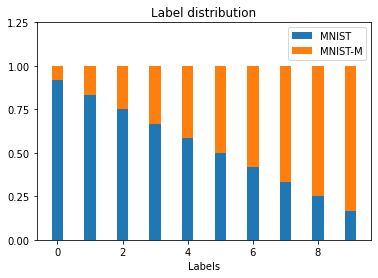

In [2]:
#TASK=2
#x_source,y_source,x_target,y_target=load_task(TASK)
from data import mnist
from data import mnist_m as mnistm
x_train, y_train, x_test, y_test = mnist.load_mnist()
        
        
###### Add train and test together 
### MNIST all data
x_full=np.append(x_train,x_test, axis=0)
y_full=np.append(y_train,y_test, axis=0)




## shift the distributions to create source and target distributions
x_shift, y_shift, x_shift_target, y_shift_target = label_shift_linear(x_full,y_full,1/12,[0,1,2,3,4,5,6,7,8,9])


#### MIXED MNIST and MNIST-m
x_train_m, y_train_m, x_test_m, y_test_m = mnistm.load_mnistm(y_train,y_test)
### MNIST-M all data
x_full_m=np.append(x_train_m,x_test_m, axis=0)
y_full_m=np.append(y_train_m,y_test_m, axis=0)
## shift the distributions to create source and target distributions
x_shift_m, y_shift_m,x_shift_target_m, y_shift_target_m = \
label_shift_linear(x_full_m,y_full_m,1/12,[0,1,2,3,4,5,6,7,8,9],decreasing=False)
##### calculate the label densities here
densities=[]
densities.append(np.sum(y_shift,axis=0))
densities.append(np.sum(y_shift_m,axis=0))
densities.append(np.sum(y_shift_target,axis=0))
densities.append(np.sum(y_shift_target_m,axis=0))

            
L=len(densities[0])
interdomain_densities = [[] for x in range(2)]
for i in range(L):
    ## all densities are (#samples from mnist) over (#samples from mnist-m)
    interdomain_densities[0].append(densities[0][i]/densities[1][i])
    interdomain_densities[1].append(densities[2][i]/densities[3][i])
print(interdomain_densities)
## add the shifted data together to create source and target
x_source=np.append(x_shift,x_shift_m, axis=0)
y_source=np.append(y_shift,y_shift_m, axis=0)
x_target=np.append(x_shift_target,x_shift_target_m, axis=0)
y_target=np.append(y_shift_target,y_shift_target_m, axis=0)

plot_splitbars([0,1,2,3,4,5,6,7,8,9],y_shift,y_shift_m,"MNIST","MNIST-M",save=True)

In [ ]:
from data.label_shift import plot_splitbars

fig=plt.imshow(x_shift[205])
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig("mnist_ex.png",dpi=600)
#plt.imshow(x_shift_m[205])

#plot_splitbars([0,1,2,3,4,5,6,7,8,9],y_shift,y_shift_m,"MNIST","MNIST-M",save=True)

# Define training functions

In [ ]:
def init_tf():
    ### making sure that we have the GPU to work on
    gpus = tf.config.experimental.list_physical_devices('GPU')
    #logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    if gpus:
      # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
      # I do not know why I have to do this but gpu does not work otherwise.
        try:
            tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
            print(e)

    
## custom callback to terminate training at some specific value of a metric
    
class stop_callback(tf.keras.callbacks.Callback):
    def __init__(self, monitor='accuracy', value=0.001, verbose=0):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy')> self.value): # select the accuracy
            print("\n !!! training error threshold reached, no further training !!!")
            self.model.stop_training = True
            
class fast_checkpoints(tf.keras.callbacks.Callback):
    def __init__(self,checkpoint_path,save_freq):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.save_freq=save_freq
        self.filepath=checkpoint_path
        self.verbose=1
        self.save_best_only=False
        self.save_weights_only=True
    def on_train_batch_begin(self, batch, epoch, logs=None):
         if batch%self.save_freq==0:

            #print("\n Saved weights at the start of batch"+str(batch)+"\n")

            ## Create folder
            weight_path = self.filepath+"/1_"+str(batch)+".ckpt"
            os.makedirs(os.path.dirname(weight_path), exist_ok=True)
            
            self.model.save_weights(weight_path)
            
def train_posterior(alpha,x_train,y_train,prior_weights=None,x_test=[],y_test=[],save=True,epsilon=0.01,Task=2,Binary=False,batch_size=128):
        
        TASK=Task
        
        ### x_test should be the whole of S for early stopping purposes
    
        checkpoint_path = "posteriors/"+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))
        if Binary:
            checkpoint_path = "posteriors/"+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))
        
        
        # Create a callback that saves the model's weights every epoch
        checkpoint_freq=np.ceil(len(x_train)/batch_size)
        #print(checkpoint_freq)
        cp_callback = tf.keras.callbacks.ModelCheckpoint(
            save_freq="epoch",#int(checkpoint_freq),### 547 = ceiling(70000/128) i.e training set for MNIST/MNIST-M,
            filepath=checkpoint_path+"/2_{epoch:0d}.ckpt", 
            verbose=1,
            save_best_only=False,
            save_weights_only=True,
                ## tune when to save as needed for plots
        )
        ## callback for first part
        fast_checkpoint_freq=np.ceil(len(x_train)/(batch_size*10))
        fast_cp_callback =fast_checkpoints(checkpoint_path,int(fast_checkpoint_freq))
        stopping_callback=stop_callback(monitor='val_acc',value=1-epsilon)
    
        M=init_task_model(TASK,Binary)

        
            
        ## choose loss function, optimiser etc. and train
        
        M.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.SGD(learning_rate=0.003, momentum=0.95),
                      metrics=['accuracy'],)
        
        
        ## Create the folder
        os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
        ## remove previous weights
        import glob
        files=glob.glob(os.path.join(checkpoint_path+'/*'))
        
        
        for file in files:
            if file==(checkpoint_path+'/params.txt'):
                files.remove(checkpoint_path+'/params.txt')
            os.remove(file)
        
        ### load the prior weights
        if prior_weights is not None:
            M.set_weights(prior_weights)
        elif(alpha==0):
            ### save the rand. init as the prior
            if Binary:
                prior_path="priors/"+"task"+str(TASK)+"/Binary/"+str(int(100*alpha))+"/prior.ckpt"
            else:
                prior_path="priors/"+"task"+str(TASK)+"/"+str(int(100*alpha))+"/prior.ckpt"
            
            ## Create the folder
            os.makedirs(os.path.dirname(prior_path), exist_ok=True)

            ## Save the weights
            M.save_weights(prior_path)
        else:
            if Binary:
                prior_path="priors/"+"task"+str(TASK)+"/Binary/"+str(int(100*alpha))+"/prior.ckpt"
                M.load_weights(prior_path).expect_partial()
            else:
                
                M.load_weights(prior_path).expect_partial()
        
    
        if save:
            CALLBACK=[fast_cp_callback,stopping_callback]
        else:
            CALLBACK=[stopping_callback]
        ### train for one epoch with more checkpoints to be able to plot more there
        fit_info = M.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=1, 
           callbacks=CALLBACK,
           validation_data=(x_test, y_test),
           verbose=0,
                        )
        
        print("-"*40)
        print("Finished training first posterior epoch")
        if save:
            CALLBACK=[cp_callback,stopping_callback]
        else:
            CALLBACK=[stopping_callback]
            
        fit_info = M.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=2000, # we should have done early stopping before this completes
           callbacks=CALLBACK,
           validation_data=(x_test, y_test),
           verbose=0,
                        )
        print("-"*40)
        print("Finished training posterior")
        
         #### save the last posterior weights to disk
        epochs_trained=len(fit_info.history['loss'])
        #if save:
            ## Create the folder
            #os.makedirs(os.path.dirname(checkpoint_path+"/2_"+str(epochs_trained)), exist_ok=True)
            
            
            #M.save_weights(checkpoint_path+"/2_"+str(epochs_trained)) ###### check if we need this; TODO!!!!!!
            
        #### save textfile with parameters, i.e. alpha ,epochs trained and epsilon
        if Binary:
            with open('posteriors/'+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+'/params.txt', 'w') as f:
                f.write('\n'.join([str(alpha), str(epsilon), str(epochs_trained)]))     
            f.close()
        else:
            with open('posteriors/'+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+'/params.txt', 'w') as f:
                f.write('\n'.join([str(alpha), str(epsilon), str(epochs_trained)]))     
            f.close()
        W=M.get_weights()
        return W
    
def train_prior(alpha,total_epochs,x_train=[],y_train=[],x_target=[],y_target=[],save=True,Task=2,Binary=False,batch_size=128):
    TASK=Task
    
    if Binary:
        ## Create the folders
        os.makedirs(os.path.dirname("priors/"+"task"+str(TASK)+"/Binary/"+str(int(100*alpha)))+"/", exist_ok=True)
        checkpoint_path = "priors/"+"task"+str(TASK)+"/Binary/"+str(int(100*alpha))
    else:
        os.makedirs(os.path.dirname("priors/"+"task"+str(TASK)+"/"+str(int(100*alpha)))+"/", exist_ok=True)
        checkpoint_path = "priors/"+"task"+str(TASK)+"/"+str(int(100*alpha))
    ## remove previous weights
    import glob
    files=glob.glob(os.path.join(checkpoint_path+'/*'))
    for file in files:
        os.remove(file)
    M=init_task_model(TASK,Binary)
    #sys.exit(-1)
    ### save checkpoints 10 times over the training of the prior
    l=len(x_train)
    checkpoint_freq=np.ceil(l/(batch_size*10))
    fast_cp_callback =fast_checkpoints(checkpoint_path,int(checkpoint_freq))
    if save:
            CALLBACK=[fast_cp_callback]
    else:
            CALLBACK=[]
            
    ## choose loss function, optimiser etc. and train
    M.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.SGD(learning_rate=0.003, momentum=0.95),
                      metrics=['accuracy'],)
    fit_info = M.fit(x_train, y_train,
           batch_size=batch_size,
           callbacks=CALLBACK,
           epochs=total_epochs,
           verbose=0,
                        )
    print("-"*40)
    print("Finished training prior")
    #### save the final prior weights to disk
    if save:
        os.makedirs(checkpoint_path, exist_ok=True)
        M.save_weights(checkpoint_path+"/prior.ckpt")
     
    
    list1=[]
    
    dirFiles = os.listdir(checkpoint_path) #list of directory files
    
    ## remove the ckpt.index and sort so that we get the epochs that are in the directory
    for files in dirFiles: #filter out all non weights
        if '.ckpt.index' in files:
            name = re.sub('\.ckpt.index$', '', files)
            if (name[0]=="1"):
                list1.append(name)
        
    list1.sort(key=lambda f: int(re.sub('\D', '', f)))
    list1.append("prior")    ## add the final weights which has no number
    
    Ws=list1
    weight_updates=[]
    for i in Ws:
        if i[0]=="1":
            if i[1]=="_":
                weight_updates.append(int(i[2:]))
    weight_updates.append(int(np.ceil(len(y_train)/batch_size)))
    
    error=[]
    target_error=[]
    for checkpoint in Ws:

        model=init_task_model(TASK,Binary)
        model.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.SGD(learning_rate=0.003, momentum=0.95),
                  metrics=['accuracy'],)
      
            
        model.load_weights(checkpoint_path+"/"+str(checkpoint)+".ckpt").expect_partial()
        target_error.append(1-model.evaluate(x_target,y_target,verbose=0)[1])
        error.append(1-model.evaluate(x_train,y_train,verbose=0)[1])
    print("-"*40)
    print("Finished computing prior sample and target errors")
    if save:
        results=pd.DataFrame({'Weightupdates': weight_updates,
            'Trainerror': error,
            'targeterror':target_error,
            })
       
        ## Create the folders
        os.makedirs(os.path.dirname(project_folder+"mnist_transfer/results/"+"task"+str(TASK)+"/Binary/"), exist_ok=True)
        if Binary:
            with open(project_folder+"mnist_transfer/results/"+"task"+str(TASK)+"/Binary/"+str(int(100*alpha))+"_prior_results.pkl",'wb') as f:
                pickle.dump(results,f)
            f.close()
        else:
            with open(project_folder+"mnist_transfer/results/"+"task"+str(TASK)+"/"+str(int(100*alpha))+"_prior_results.pkl",'wb') as f:
                pickle.dump(results,f)
            f.close()
    return model.get_weights()
    


def plot_result_file(epsilon,alpha,sigma,Binary=False,Task=2):
    sigma_tmp=sigma
    sigma=sigma[0]*10**(-1*sigma[1])
    
    if Binary:
        result_path="results/"+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"+str(sigma_tmp[0])+str(sigma_tmp[1])
        plt.title("Binary: "+r"$\alpha$="+str(alpha)+r" $\epsilon$="+str(epsilon)+r" $\sigma$="+str(sigma))
    else:
        result_path="results/"+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"+str(sigma_tmp[0])+str(sigma_tmp[1])
        plt.title(r"$\alpha$="+str(alpha)+r" $\epsilon$="+str(epsilon)+r" $\sigma$="+str(sigma))
    results=pd.read_pickle(result_path+"_results.pkl")
    
    ### do the plots
    plt.plot(results["Weightupdates"],results["Bound"],'r*-')
    plt.plot(results["Weightupdates"],results["Trainerror"],'m^-')
    
    plt.xlabel("Weight updates")
    plt.ylabel("Error")
    
    plt.legend(["Bound","Empirical error"])
    plt.show()

def find_optimal_sigma(sigmas,epsilon, alpha,Binary=False,Task=2):
    #### to find the optimal sigma just do a search through all the results 
    #### and save the one for each parameter which has the minimal bound
    #### Do we do this per epoch or for some other value? The sigma which yields the lowest bound overall for some epoch?
    optimal=[0,1]
    # search through all epochs and pick the sigma which yields the smallest bound during the whole training process
    for sigma in sigmas:
        sigma_tmp=sigma
        sigma=sigma[0]*10**(-1*sigma[1])
        if Binary:
            result_path="results/"+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"+str(sigma_tmp[0])+str(sigma_tmp[1])
        else:
            result_path="results/"+"task"+str(TASK)+"/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"+str(sigma_tmp[0])+str(sigma_tmp[1])
        results=pd.read_pickle(result_path+"_results.pkl")
        MIN=np.min(results["Bound"])
        if (MIN<optimal[1]):
            optimal[1]=MIN
            optimal[0]=sigma
    print("The optimal sigma is {} with bound value {}".format(optimal[0],optimal[1]))

   
#### find the optimal sigma for every combination of parameters

#### use the optimal sigmas to calculate the bound 50 times(with different data orders and initialisation)
#### (Note: also delta=13*delta_0) for every combination 
# def read_prior(alpha,TASK=2,Binary=True):
#     checkpoint_path = "priors/"+"task"+str(TASK)+"/"+str(int(100*alpha))
#     if Binary:
#         checkpoint_path = "priors/"+"task"+str(TASK)+"/Binary/"+str(int(100*alpha))
#     result_path=project_folder+'mnist_transfer/'+checkpoint_path+"/results.pkl"
#     results=pd.read_pickle(result_path)
#     plt.title(r"$\alpha$="+str(alpha))
#     plt.plot(results["Weightupdates"],results["Trainerror"],'m^-')
#     plt.plot(results["Weightupdates"],results["targeterror"],'k^-')
#     plt.legend(["Training error","Target error"])
    
# def plot_prior_and_posterior(alpha,epsilon,sigma,TASK=2,Binary=True):
#     ### load in the prior data
#     sigma_tmp=sigma
#     sigma=sigma[0]*10**(-1*sigma[1])
#     checkpoint_path = "priors/"+"task"+str(TASK)+"/"+str(int(100*alpha))
#     if Binary:
#         checkpoint_path = "priors/"+"task"+str(TASK)+"/Binary/"+str(int(100*alpha))
#     result_path=project_folder+'mnist_transfer/'+checkpoint_path+"/results.pkl"
#     results=pd.read_pickle(result_path)
#     result_path_post="results/"+"task"+str(TASK)+"/Binary/"+str(int(1000*epsilon))+"_"+str(int(100*alpha))+"_"+str(sigma_tmp[0])+str(sigma_tmp[1])
#     results2=pd.read_pickle(result_path_post+"_results.pkl")
    
    
#     ### remove/ignore the last entry of the prior data 
#     ### as it should be a duplication of the first one from the posterior results
    
#     ### training error
#     A=list(results2["Weightupdates"]+list(results["Weightupdates"])[-1])
#     B=list(results["Weightupdates"])[:-1]
#     B.extend(A)
#     C=list(results["Trainerror"])[:-1]
#     C.extend(list(results2["train_germain"]))
#     plt.plot(B,C,'-m^')
    
#     ## target error
#     D=list(results["targeterror"])[:-1]
#     D.extend(list(results2["target_germain"]))
#     plt.plot(B,D,'-k*')
    
#     ### bound
#     E=results2["germain_bound"]
#     plt.plot(A,E,'-D')
#     F=results2['boundpart3_germain']
#     plt.plot(A,F,'-o')
#     print(results2["target_germain"])
#     print(results2["germain_bound"])
#     ### lines for uninformative region and worse than random guessing; also for end of prior training
#     plt.axvline(A[0],color="grey")
#     plt.axhline(y=0.5, color="black", linestyle="--")
#     plt.axhline(y=1, color="red", linestyle="--")
#     plt.legend(["Training error","Target error","Bound","KL-part"])

# Training

In [ ]:
#alphas=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
alphas=[0,0.8]
epsilons=[0.03]#,0.01,0.001]
tasks=[2]
for t in tasks:
    x_source,y_source,x_target,y_target=load_task(t)

    y_source_bin=np.array(make_mnist_binary(y_source))
    y_target_bin=np.array(make_mnist_binary(y_target))
    for alpha in alphas:
        if alpha==0:
            pass
        else:
            print("Alpha is:"+str(alpha))
            x_bound, x_prior, y_bound , y_prior = train_test_split(x_source,y_source_bin,test_size=alpha,random_state=69105)
            w_a=train_prior(alpha,1,x_source,y_source_bin,x_target=x_target,y_target=y_target_bin,save=True,Task=t,Binary=True,batch_size=128)
        for epsilon in epsilons:
            w_s=train_posterior(alpha,x_source,y_source_bin,None,x_test=x_source,y_test=y_source_bin,epsilon=epsilon,Task=t,Binary=True,batch_size=128)
            #for sigma in sigmas:
                #res=read_and_prepare_results(alpha,x_source,y_source_bin,x_target,y_target_bin,sigma,delta,len(x_source),epsilon,Binary=True)#x_bound,y_bound,x_target,y_target_bin,sigma,delta,len(x_bound),epsilon,Binary=True)
                #plot_result_file(epsilon,alpha,sigma,TASK,Binary=True)